<a href="https://colab.research.google.com/github/dimsparagis0210/DFU-using-Deep-Learning/blob/main/YOLOv11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Πτυχιακή Εργασία

#### The goal of this BSc thesis is to develop a Deep Learning model for Object Detection. Specifically, the object of the model will be to detect ulcers in Diabetic Foots (DFU)

## Getting Dataset from Google drive

In [6]:
from google.colab import drive

drive.mount('/content/drive')

# train: /content/drive/MyDrive/DFU_Data_Yolo/train/images
# val: /content/drive/MyDrive/DFU_Data_Yolo/valid/images
# test: /content/drive/MyDrive/DFU_Data_Yolo/test/images

# nc: 1
# names: ['Ulcer-W7iN']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os

# Define dataset path (adjust if needed)
dataset = '/content/drive/MyDrive/DFU_Data_Yolo'
trainset = dataset + '/train/images'
testset = dataset + '/test/images'
validset = dataset + '/valid/images'

# List categories (folders)
os.listdir(dataset)

['README.dataset.txt',
 'README.roboflow.txt',
 'train',
 'valid',
 'test',
 'data.yaml']

In [3]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import cv2

## Data Exploration

### Average Images

In [4]:
def compute_average_image(image_dir, img_size=(224, 224)):
    all_images = []
    for file_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, file_name)
        try:
            with Image.open(img_path) as img:
                img = img.convert("RGB").resize(img_size)
                all_images.append(np.array(img, dtype=np.float32))
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    if all_images:
        mean_image = np.mean(all_images, axis=0).astype(np.uint8)
        return mean_image
    else:
        print(f"No images found in {image_dir}.")
        return None


In [5]:
# Compute average image for image patches
average_image = compute_average_image(trainset)

#### Visualizing Averages of the Dataset

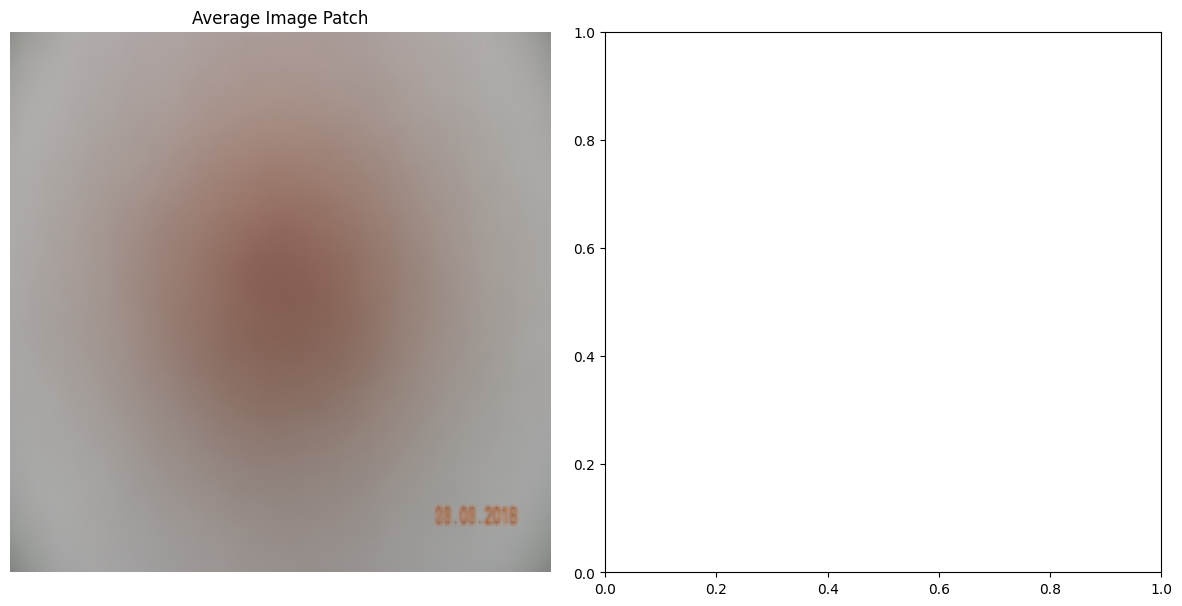

In [8]:
# Plotting the average images
fig, axes = plt.subplots(1,2, figsize=(12, 6))

if average_image is not None:
    axes[0].imshow(average_image)
    axes[0].set_title("Average Image Patch")
    axes[0].axis("off")
else:
    axes[0].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center')
    axes[0].set_title("Average Image Patch")
    axes[0].axis("off")

plt.tight_layout()
plt.show()



### Comparing sizes of the images in the dataset

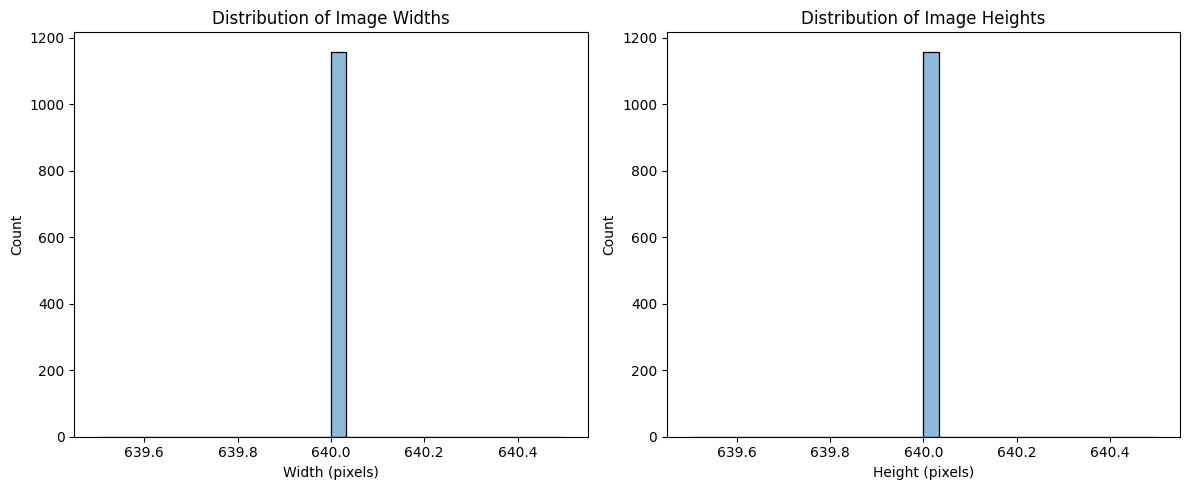

In [9]:
widths = []
heights = []

for filename in os.listdir(trainset):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        with Image.open(os.path.join(trainset, filename)) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(widths, bins=30, kde=True)
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')

plt.subplot(1, 2, 2)
sns.histplot(heights, bins=30, kde=True)
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')

plt.tight_layout()
plt.show()


## Data Preprocessing

### Reading Dataset using Tensoflow

In [10]:
# Load dataset
batch_size = 32
img_size = (640, 640)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    'drive/MyDrive/DFU_Data_Yolo/train',
    validation_split = 0.2,
    subset = "training",
    shuffle = True,
    seed = 123,
    batch_size=batch_size,
    image_size=img_size
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    'drive/MyDrive/DFU_Data_Yolo/valid',
    validation_split = 0.2,
    subset = "validation",
    shuffle=True,
    seed = 123,
    batch_size=batch_size,
    image_size=img_size
)

# Get class names
class_names = train_dataset.class_names

Found 1159 files belonging to 2 classes.
Using 928 files for training.
Found 331 files belonging to 2 classes.
Using 66 files for validation.


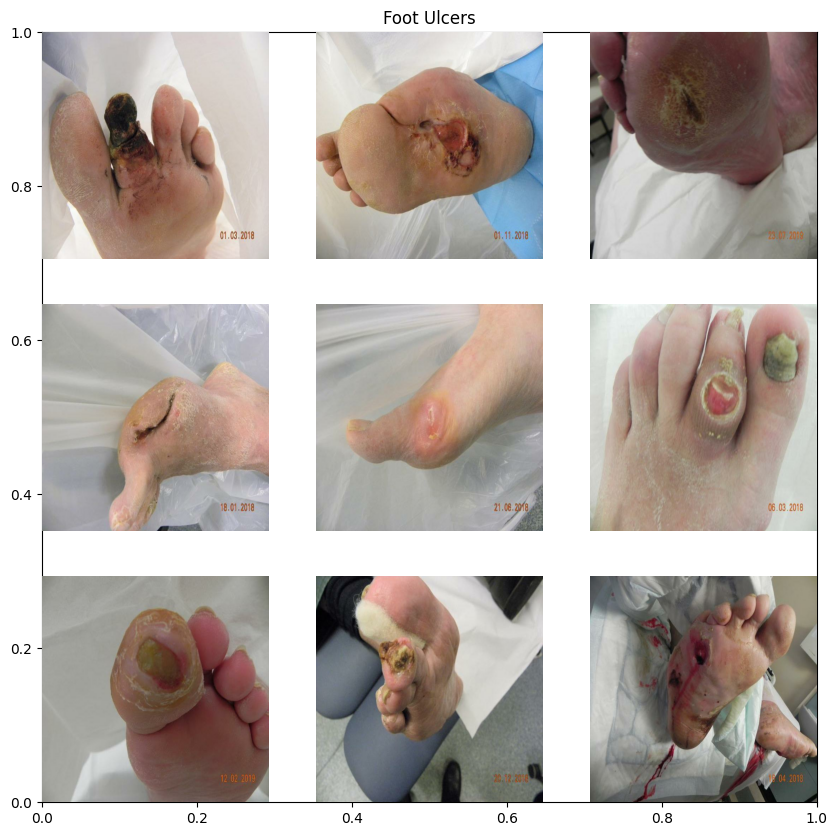

In [11]:
# Get a batch of images
plt.figure(figsize=(10, 10))
plt.title('Foot Ulcers')
for images, labels in train_dataset.take(1):  # Take one batch
    for i in range(9):  # Show 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

### Normalize Images Layer(Divide Pixel values with 255)

In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

### Data Augmentation Layer

In [13]:
from keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.2),
    # Add other augmentation layers as needed
])

### Apply the preprocessing steps to the train and validation set

In [14]:
def preprocess(image, label):
    image = data_augmentation(image)
    image = normalization_layer(image)
    return image, label

train_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)

## Model Training

### YOLOv11

In [15]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (8 CPUs, 51.0 GB RAM, 41.1/235.7 GB disk)


In [15]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 25.5 MB/s eta 0:00:00


#### Hyperparameter Optimization

In [112]:
import os
from glob import glob

val_images_dir = '/content/drive/MyDrive/DFU_Data_Yolo/valid/images'
val_labels_dir = '/content/drive/MyDrive/DFU_Data_Yolo/valid/labels'

# Ensure labels directory exists
os.makedirs(val_labels_dir, exist_ok=True)

# Get basenames of existing images and labels
image_files = glob(os.path.join(val_images_dir, '*.jpg'))
image_basenames = [os.path.splitext(os.path.basename(f))[0] for f in image_files]

for basename in image_basenames:
    label_path = os.path.join(val_labels_dir, basename + '.txt')
    if not os.path.exists(label_path):
        # Create empty file if it doesn't exist
        open(label_path, 'w').close()

print(f"✅ Ensured all images in val/images have corresponding .txt files in val/labels")

✅ Ensured all images in val/images have corresponding .txt files in val/labels


In [54]:
import optuna
import os
from ultralytics import YOLO

# Define your search space for numerical hyperparameters
search_space = {
    'lr0': (1e-4, 1e-2),
    'momentum': (0.85, 0.95),
    'weight_decay': (1e-5, 1e-3),
    'scale': (0.0, 1.0),         # ✅ this is valid
    'translate': (0.0, 0.2),
}

# Dataset yaml
my_yaml = '/content/drive/MyDrive/DFU_Data_Yolo/data.yaml'


def objective(trial):
    # Define hyperparameters to be tuned by Optuna
    params = {
        "lr0": trial.suggest_float("lr0", search_space["lr0"][0], search_space["lr0"][1]),
        "momentum": trial.suggest_float("momentum", search_space["momentum"][0], search_space["momentum"][1]),
        "weight_decay": trial.suggest_float("weight_decay", search_space["weight_decay"][0], search_space["weight_decay"][1]),
        "scale": trial.suggest_float("scale", search_space["scale"][0], search_space["scale"][1]),
        "translate": trial.suggest_float("translate", search_space["translate"][0], search_space["translate"][1]),
        "optimizer": trial.suggest_categorical("optimizer", ['sgd', 'adam', 'adamw']),  # Optimizer choices
    }

    # Load your YOLOv11 model
    model = YOLO('yolo11n.pt')

    # Train the model with the suggested hyperparameters
    model.train(
        data=my_yaml,
        epochs=10,  # Consider reducing for faster trials
        batch=16,
        imgsz=640,
        **params, # Pass the hyperparameters to the training function
        save=True
    )

    # Evaluate the model and return a metric to optimize (e.g., mAP@0.5)
    results = model.val(data=my_yaml, split='val')
    return results.box.map50  # Use mAP@0.5 as the objective metric

# Create an Optuna study
study = optuna.create_study(direction="maximize")  # Maximize mAP@0.5

# Run the optimization
study.optimize(objective, n_trials=10)  # Number of trials to run

# Print the best hyperparameters and results
print("Best hyperparameters:", study.best_params)
print("Best mAP@0.5:", study.best_value)

[I 2025-04-21 12:07:06,774] A new study created in memory with name: no-name-908d8c3b-5812-47cd-bf1e-bf297fd7b4af


Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/DFU_Data_Yolo/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=sgd, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

train: Scanning /content/drive/MyDrive/DFU_Data_Yolo/train/labels.cache... 1159 images, 5 backgrounds, 0 corrupt: 100%|██████████| 1159/1159 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 2.7±5.0 ms, read: 3.9±2.3 MB/s, size: 33.0 KB)


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 331 images, 3 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]


Plotting labels to runs/detect/train11/labels.jpg... 
optimizer: SGD(lr=0.006255102091385458, momentum=0.8752484796408436) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00039597044957054517), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train11
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.32G      1.868       4.18       1.74          7        640: 100%|██████████| 73/73 [00:13<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.19it/s]

                   all        331        386    0.00342      0.881      0.154     0.0611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10       2.7G      1.803      2.679      1.669          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.37it/s]

                   all        331        386      0.472      0.479      0.467      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10       2.7G      1.815      2.218      1.609          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.49it/s]

                   all        331        386      0.553      0.509      0.512       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10       2.7G      1.783      1.998      1.576          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.53it/s]

                   all        331        386      0.629      0.523      0.546      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10       2.7G      1.752      1.887      1.485          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.62it/s]

                   all        331        386      0.408      0.298      0.294       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       2.7G      1.729        1.8      1.491          6        640: 100%|██████████| 73/73 [00:11<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.59it/s]

                   all        331        386      0.629      0.661      0.693       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10       2.7G      1.677      1.673      1.439          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.57it/s]

                   all        331        386      0.726      0.668      0.745      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10       2.7G      1.611      1.592      1.411          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.51it/s]

                   all        331        386      0.749      0.664      0.741      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10       2.7G      1.607      1.499       1.37          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.26it/s]

                   all        331        386      0.734      0.707      0.789      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       2.7G      1.584      1.488      1.362          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.30it/s]

                   all        331        386      0.767      0.684      0.778      0.412



10 epochs completed in 0.040 hours.
Optimizer stripped from runs/detect/train11/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train11/weights/best.pt, 5.5MB

Validating runs/detect/train11/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.98it/s]


                   all        331        386      0.766      0.687      0.781      0.411
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train11
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 25.4±9.9 MB/s, size: 30.7 KB)


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 331 images, 3 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.53it/s]


                   all        331        386      0.767      0.687       0.78      0.412
Speed: 0.8ms preprocess, 4.0ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train112


[I 2025-04-21 12:09:50,939] Trial 0 finished with value: 0.7804756009104682 and parameters: {'lr0': 0.006255102091385458, 'momentum': 0.8752484796408436, 'weight_decay': 0.00039597044957054517, 'scale': 0.8218177248441648, 'translate': 0.1292814473727828, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7804756009104682.


Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/DFU_Data_Yolo/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=sgd, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

train: Scanning /content/drive/MyDrive/DFU_Data_Yolo/train/labels.cache... 1159 images, 5 backgrounds, 0 corrupt: 100%|██████████| 1159/1159 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.8±0.5 ms, read: 3.3±2.0 MB/s, size: 33.0 KB)


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 331 images, 3 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]


Plotting labels to runs/detect/train12/labels.jpg... 
optimizer: SGD(lr=0.006567028369842827, momentum=0.9483389457417855) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.000377249536001269), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train12
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.35G      1.837       4.02      1.723          7        640: 100%|██████████| 73/73 [00:13<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.20it/s]

                   all        331        386          1     0.0288      0.309      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.52G      1.788      2.458        1.7          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.54it/s]

                   all        331        386      0.417      0.334      0.278      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.52G      1.868      2.085      1.574          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.59it/s]

                   all        331        386      0.397      0.427       0.36      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.53G      1.842      1.961      1.577          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.48it/s]

                   all        331        386      0.515      0.562      0.508      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.53G      1.833      1.913      1.592          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.67it/s]

                   all        331        386      0.504      0.288      0.328      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.53G       1.82      1.767      1.559          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.46it/s]

                   all        331        386       0.57       0.44      0.456       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.53G      1.762      1.666      1.488          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.61it/s]

                   all        331        386      0.687      0.588      0.657      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.53G      1.752      1.581      1.481          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.64it/s]

                   all        331        386       0.72      0.632      0.725      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.53G      1.677      1.494      1.427          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.68it/s]

                   all        331        386      0.747      0.689      0.767      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.53G       1.64      1.443       1.42          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.53it/s]

                   all        331        386       0.74      0.679      0.764      0.385



10 epochs completed in 0.040 hours.
Optimizer stripped from runs/detect/train12/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train12/weights/best.pt, 5.5MB

Validating runs/detect/train12/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.90it/s]


                   all        331        386      0.741      0.679      0.764      0.384
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train12
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 21.4±6.4 MB/s, size: 30.7 KB)


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 331 images, 3 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.69it/s]


                   all        331        386      0.799      0.651      0.764      0.387
Speed: 0.8ms preprocess, 3.7ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train122


[I 2025-04-21 12:12:33,944] Trial 1 finished with value: 0.7643846304973179 and parameters: {'lr0': 0.006567028369842827, 'momentum': 0.9483389457417855, 'weight_decay': 0.000377249536001269, 'scale': 0.7309691549977094, 'translate': 0.035950943772884415, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7804756009104682.


Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/DFU_Data_Yolo/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train13, exist_ok=False, pretrained=True, optimizer=sgd, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

train: Scanning /content/drive/MyDrive/DFU_Data_Yolo/train/labels.cache... 1159 images, 5 backgrounds, 0 corrupt: 100%|██████████| 1159/1159 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


WARNING ⚠️ val: Slow image access detected (ping: 38.3±82.1 ms, read: 2.5±2.9 MB/s, size: 33.0 KB). Use local storage instead of remote/mounted storage for better performance. See https://docs.ultralytics.com/guides/model-training-tips/


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 331 images, 3 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]


Plotting labels to runs/detect/train13/labels.jpg... 
optimizer: SGD(lr=0.0074151532488651575, momentum=0.9421093069717865) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0002660851868213398), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train13
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.35G       1.88      4.039       1.69          7        640: 100%|██████████| 73/73 [00:13<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.30it/s]

                   all        331        386    0.00342      0.881       0.23      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.52G      1.868        2.6      1.641          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.55it/s]

                   all        331        386      0.288      0.246      0.189      0.086



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.53G      1.845       2.16      1.567          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.65it/s]

                   all        331        386       0.41      0.362      0.297       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.54G      1.897      2.071      1.634          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.42it/s]

                   all        331        386      0.454      0.402      0.376      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.54G       1.89       1.96      1.574          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]

                   all        331        386      0.558      0.554      0.528      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.54G      1.832      1.823      1.577          6        640: 100%|██████████| 73/73 [00:11<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.61it/s]

                   all        331        386      0.648      0.521      0.593      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.54G      1.812       1.69      1.511          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.50it/s]

                   all        331        386      0.634       0.65      0.672      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.54G      1.743      1.595       1.48          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.58it/s]

                   all        331        386      0.577      0.557      0.579      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.54G      1.717       1.53      1.426          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.55it/s]

                   all        331        386      0.716      0.726       0.77      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.54G      1.677      1.494       1.41          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.48it/s]

                   all        331        386      0.727      0.681      0.764      0.378



10 epochs completed in 0.039 hours.
Optimizer stripped from runs/detect/train13/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train13/weights/best.pt, 5.5MB

Validating runs/detect/train13/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.06it/s]


                   all        331        386      0.725      0.684      0.764      0.378
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train13
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 23.6±8.0 MB/s, size: 30.7 KB)


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 331 images, 3 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.55it/s]


                   all        331        386      0.725      0.682      0.764      0.377
Speed: 0.8ms preprocess, 3.9ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train132


[I 2025-04-21 12:15:19,775] Trial 2 finished with value: 0.764322896560115 and parameters: {'lr0': 0.0074151532488651575, 'momentum': 0.9421093069717865, 'weight_decay': 0.0002660851868213398, 'scale': 0.8882299520451937, 'translate': 0.1162501089991464, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7804756009104682.


Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/DFU_Data_Yolo/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train14, exist_ok=False, pretrained=True, optimizer=sgd, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

train: Scanning /content/drive/MyDrive/DFU_Data_Yolo/train/labels.cache... 1159 images, 5 backgrounds, 0 corrupt: 100%|██████████| 1159/1159 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


WARNING ⚠️ val: Slow image access detected (ping: 52.5±109.1 ms, read: 3.1±3.0 MB/s, size: 33.0 KB). Use local storage instead of remote/mounted storage for better performance. See https://docs.ultralytics.com/guides/model-training-tips/


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 331 images, 3 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]


Plotting labels to runs/detect/train14/labels.jpg... 
optimizer: SGD(lr=0.0014964490325784735, momentum=0.942251747221093) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.000905395393764604), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train14
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.35G      1.798      4.144      1.698          7        640: 100%|██████████| 73/73 [00:13<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.24it/s]

                   all        331        386    0.00305      0.785    0.00668    0.00284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.52G      1.677      3.244      1.558          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.32it/s]

                   all        331        386      0.531       0.44      0.449      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.53G      1.686      2.297      1.611          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.34it/s]

                   all        331        386       0.53      0.648      0.593      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.54G      1.667      1.951      1.545          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.35it/s]

                   all        331        386      0.675       0.58      0.645      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.54G      1.609      1.788      1.472          7        640: 100%|██████████| 73/73 [00:12<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.43it/s]

                   all        331        386      0.787      0.632      0.746      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.54G      1.567      1.661       1.42          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.39it/s]

                   all        331        386      0.719      0.715      0.761      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.54G      1.531      1.575      1.375          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.50it/s]

                   all        331        386      0.733      0.697      0.767      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.54G      1.486      1.491      1.361          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.33it/s]

                   all        331        386      0.795      0.645      0.756      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.54G      1.471      1.443      1.339          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.32it/s]

                   all        331        386      0.769       0.72      0.793      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.54G      1.459      1.415      1.331          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.45it/s]

                   all        331        386      0.751       0.71      0.796      0.416



10 epochs completed in 0.039 hours.
Optimizer stripped from runs/detect/train14/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train14/weights/best.pt, 5.5MB

Validating runs/detect/train14/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.89it/s]


                   all        331        386      0.752       0.71      0.796      0.415
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train14
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.0 ms, read: 25.6±8.8 MB/s, size: 30.7 KB)


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 331 images, 3 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


                   all        331        386      0.753       0.71      0.796      0.417
Speed: 0.9ms preprocess, 3.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train142


[I 2025-04-21 12:18:06,165] Trial 3 finished with value: 0.7955454767849608 and parameters: {'lr0': 0.0014964490325784735, 'momentum': 0.942251747221093, 'weight_decay': 0.000905395393764604, 'scale': 0.15364426111365936, 'translate': 0.06591363898999432, 'optimizer': 'sgd'}. Best is trial 3 with value: 0.7955454767849608.


Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/DFU_Data_Yolo/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train15, exist_ok=False, pretrained=True, optimizer=adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

train: Scanning /content/drive/MyDrive/DFU_Data_Yolo/train/labels.cache... 1159 images, 5 backgrounds, 0 corrupt: 100%|██████████| 1159/1159 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.7±0.4 ms, read: 5.8±4.6 MB/s, size: 33.0 KB)


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 331 images, 3 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]


Plotting labels to runs/detect/train15/labels.jpg... 
optimizer: Adam(lr=0.0042208709344892055, momentum=0.8795332620672828) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0004431174190870417), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train15
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.36G      2.101      2.677      1.875          7        640: 100%|██████████| 73/73 [00:13<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.70it/s]

                   all        331        386      0.048     0.0311     0.0118    0.00374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.53G      2.121       2.01      1.951          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.65it/s]

                   all        331        386     0.0535      0.111     0.0224    0.00712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.56G      2.089      1.986      1.864          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.57it/s]

                   all        331        386      0.117      0.124     0.0494     0.0199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.57G      2.045      1.903      1.874          8        640: 100%|██████████| 73/73 [00:12<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.64it/s]

                   all        331        386      0.434      0.344        0.3      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.57G          2      1.759      1.771          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.79it/s]

                   all        331        386      0.351       0.36      0.315      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.57G      1.914      1.726      1.756          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.71it/s]

                   all        331        386      0.509      0.526       0.53      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.57G      1.869      1.591      1.674          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.61it/s]

                   all        331        386      0.578      0.537      0.585      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.57G      1.799      1.493      1.644          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.63it/s]

                   all        331        386      0.658      0.592      0.645      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.57G       1.75       1.45      1.589          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.57it/s]

                   all        331        386      0.626      0.591       0.64      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.57G      1.691      1.377       1.56          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.35it/s]

                   all        331        386       0.67      0.685      0.722      0.365



10 epochs completed in 0.040 hours.
Optimizer stripped from runs/detect/train15/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train15/weights/best.pt, 5.5MB

Validating runs/detect/train15/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.98it/s]


                   all        331        386      0.671      0.686      0.721      0.365
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train15
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 21.9±5.1 MB/s, size: 30.7 KB)


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 331 images, 3 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.53it/s]


                   all        331        386      0.671      0.687      0.722      0.364
Speed: 0.9ms preprocess, 3.8ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train152


[I 2025-04-21 12:20:51,072] Trial 4 finished with value: 0.721744673424062 and parameters: {'lr0': 0.0042208709344892055, 'momentum': 0.8795332620672828, 'weight_decay': 0.0004431174190870417, 'scale': 0.526179949507501, 'translate': 0.16847570755051317, 'optimizer': 'adam'}. Best is trial 3 with value: 0.7955454767849608.


Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/DFU_Data_Yolo/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train16, exist_ok=False, pretrained=True, optimizer=sgd, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

train: Scanning /content/drive/MyDrive/DFU_Data_Yolo/train/labels.cache... 1159 images, 5 backgrounds, 0 corrupt: 100%|██████████| 1159/1159 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


WARNING ⚠️ val: Slow image access detected (ping: 77.9±172.3 ms, read: 5.0±7.7 MB/s, size: 33.0 KB). Use local storage instead of remote/mounted storage for better performance. See https://docs.ultralytics.com/guides/model-training-tips/


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 331 images, 3 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]


Plotting labels to runs/detect/train16/labels.jpg... 
optimizer: SGD(lr=0.008771029647727357, momentum=0.8500929081481575) with parameter groups 81 weight(decay=0.0), 88 weight(decay=8.29137921618997e-05), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train16
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.36G      1.826      3.934      1.648          7        640: 100%|██████████| 73/73 [00:13<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.28it/s]

                   all        331        386      0.401      0.282      0.259      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.53G       1.82      2.482      1.633          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.44it/s]

                   all        331        386      0.598      0.523      0.509      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.54G      1.814      2.112      1.562          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.51it/s]

                   all        331        386       0.56      0.573      0.569      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.55G      1.798      1.958      1.545          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.64it/s]

                   all        331        386      0.483       0.49      0.476      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.55G      1.763      1.806      1.488          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.76it/s]

                   all        331        386      0.529      0.513      0.534      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.55G      1.705      1.716       1.47          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.47it/s]

                   all        331        386       0.67      0.624      0.692      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.55G      1.677      1.594      1.415          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.56it/s]

                   all        331        386      0.701      0.707      0.767       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.55G      1.629       1.49       1.38          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.34it/s]

                   all        331        386      0.657      0.681      0.704      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.55G      1.603      1.447      1.345          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.23it/s]

                   all        331        386      0.765        0.7      0.782      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.55G      1.553      1.402      1.333          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.46it/s]

                   all        331        386      0.792      0.694        0.8      0.417



10 epochs completed in 0.039 hours.
Optimizer stripped from runs/detect/train16/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train16/weights/best.pt, 5.5MB

Validating runs/detect/train16/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.97it/s]


                   all        331        386      0.794      0.699      0.802      0.418
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train16
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 19.3±4.7 MB/s, size: 30.7 KB)


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 331 images, 3 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.26it/s]


                   all        331        386      0.789      0.697        0.8      0.417
Speed: 0.9ms preprocess, 3.8ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train162


[I 2025-04-21 12:23:37,037] Trial 5 finished with value: 0.79952569987207 and parameters: {'lr0': 0.008771029647727357, 'momentum': 0.8500929081481575, 'weight_decay': 8.29137921618997e-05, 'scale': 0.6563862144272367, 'translate': 0.1159972861285646, 'optimizer': 'sgd'}. Best is trial 5 with value: 0.79952569987207.


Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/DFU_Data_Yolo/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train17, exist_ok=False, pretrained=True, optimizer=adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

train: Scanning /content/drive/MyDrive/DFU_Data_Yolo/train/labels.cache... 1159 images, 5 backgrounds, 0 corrupt: 100%|██████████| 1159/1159 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 2.7±3.0 ms, read: 3.6±4.4 MB/s, size: 33.0 KB)


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 331 images, 3 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]


Plotting labels to runs/detect/train17/labels.jpg... 
optimizer: Adam(lr=0.0011454174127958556, momentum=0.9193609546663296) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0001902414291929984), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train17
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.36G      1.895      2.512      1.709          7        640: 100%|██████████| 73/73 [00:13<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.78it/s]

                   all        331        386      0.381      0.161      0.143     0.0659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.53G        1.8      1.635       1.64          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.71it/s]

                   all        331        386      0.313      0.205      0.175     0.0809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.55G      1.787      1.571      1.599          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.74it/s]

                   all        331        386      0.239      0.254       0.16     0.0701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.57G      1.749      1.499      1.594          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.70it/s]

                   all        331        386      0.642      0.623      0.649      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.57G      1.724      1.399      1.565          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.66it/s]

                   all        331        386      0.685      0.611      0.671      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.57G      1.699      1.322      1.518          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.59it/s]

                   all        331        386      0.701      0.679      0.721      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.57G      1.642      1.272      1.485          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.44it/s]

                   all        331        386      0.703      0.688      0.742      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.57G      1.596       1.19      1.438          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.47it/s]

                   all        331        386      0.732      0.666      0.741      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.57G      1.563      1.111        1.4          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.51it/s]

                   all        331        386       0.76       0.72      0.792      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.57G      1.509      1.088      1.378          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.69it/s]

                   all        331        386      0.736      0.725      0.786      0.415



10 epochs completed in 0.039 hours.
Optimizer stripped from runs/detect/train17/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train17/weights/best.pt, 5.5MB

Validating runs/detect/train17/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.05it/s]


                   all        331        386      0.738      0.725      0.787      0.415
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train17
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.1 ms, read: 27.5±5.6 MB/s, size: 30.7 KB)


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 331 images, 3 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


                   all        331        386      0.729      0.732      0.786      0.416
Speed: 0.9ms preprocess, 3.9ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train172


[I 2025-04-21 12:26:25,011] Trial 6 finished with value: 0.7862939515127927 and parameters: {'lr0': 0.0011454174127958556, 'momentum': 0.9193609546663296, 'weight_decay': 0.0001902414291929984, 'scale': 0.28122105236949546, 'translate': 0.13618117649191724, 'optimizer': 'adam'}. Best is trial 5 with value: 0.79952569987207.


Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/DFU_Data_Yolo/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train18, exist_ok=False, pretrained=True, optimizer=sgd, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

train: Scanning /content/drive/MyDrive/DFU_Data_Yolo/train/labels.cache... 1159 images, 5 backgrounds, 0 corrupt: 100%|██████████| 1159/1159 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


WARNING ⚠️ val: Slow image access detected (ping: 15.9±31.9 ms, read: 9.9±9.0 MB/s, size: 33.0 KB). Use local storage instead of remote/mounted storage for better performance. See https://docs.ultralytics.com/guides/model-training-tips/


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 331 images, 3 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]


Plotting labels to runs/detect/train18/labels.jpg... 
optimizer: SGD(lr=0.0015992524486257733, momentum=0.8740917410748081) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0006504411211317117), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train18
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.36G      1.806      4.165      1.692          7        640: 100%|██████████| 73/73 [00:13<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.42it/s]

                   all        331        386    0.00301      0.775     0.0137    0.00598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.53G       1.67      3.319      1.535          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.26it/s]

                   all        331        386      0.487       0.43      0.429      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.54G      1.676      2.377      1.557          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.25it/s]

                   all        331        386      0.582      0.591      0.604      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.55G      1.671      2.054      1.549          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.24it/s]

                   all        331        386      0.666       0.65      0.677      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.55G      1.614      1.878      1.487          7        640: 100%|██████████| 73/73 [00:12<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.10it/s]

                   all        331        386      0.704      0.653      0.732       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.55G      1.558      1.761      1.429          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.30it/s]

                   all        331        386      0.716      0.702      0.759      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.55G      1.529      1.678      1.396          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.45it/s]

                   all        331        386      0.693      0.705      0.769      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.55G      1.518      1.608      1.374          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.27it/s]

                   all        331        386      0.761      0.692      0.777      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.55G      1.489      1.581      1.351          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.40it/s]

                   all        331        386      0.757      0.717      0.795      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.55G       1.48      1.553      1.346          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.30it/s]

                   all        331        386      0.773      0.686      0.796      0.408



10 epochs completed in 0.039 hours.
Optimizer stripped from runs/detect/train18/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train18/weights/best.pt, 5.5MB

Validating runs/detect/train18/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.87it/s]


                   all        331        386      0.753      0.715      0.795      0.415
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train18
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.1 ms, read: 23.5±10.5 MB/s, size: 30.7 KB)


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 331 images, 3 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


                   all        331        386      0.752      0.715      0.795      0.417
Speed: 0.9ms preprocess, 3.9ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train182


[I 2025-04-21 12:29:11,663] Trial 7 finished with value: 0.7945181175171906 and parameters: {'lr0': 0.0015992524486257733, 'momentum': 0.8740917410748081, 'weight_decay': 0.0006504411211317117, 'scale': 0.1418451590597818, 'translate': 0.07168281503363061, 'optimizer': 'sgd'}. Best is trial 5 with value: 0.79952569987207.


Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/DFU_Data_Yolo/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train19, exist_ok=False, pretrained=True, optimizer=adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

train: Scanning /content/drive/MyDrive/DFU_Data_Yolo/train/labels.cache... 1159 images, 5 backgrounds, 0 corrupt: 100%|██████████| 1159/1159 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.4±0.0 ms, read: 21.9±10.7 MB/s, size: 33.0 KB)


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 331 images, 3 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]


Plotting labels to runs/detect/train19/labels.jpg... 
optimizer: Adam(lr=0.0006970663820592424, momentum=0.8504136690844623) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0003579067000869818), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train19
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.38G      1.888      2.514      1.739          7        640: 100%|██████████| 73/73 [00:13<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.99it/s]

                   all        331        386      0.161      0.456       0.23      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.54G      1.815      1.634      1.651          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.67it/s]

                   all        331        386      0.454       0.36      0.363      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.54G      1.806      1.548      1.619          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.68it/s]

                   all        331        386      0.632       0.48      0.549      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.55G      1.735      1.471      1.607          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.58it/s]

                   all        331        386      0.586      0.635       0.63      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.56G      1.704      1.383      1.566          7        640: 100%|██████████| 73/73 [00:12<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.40it/s]

                   all        331        386      0.693      0.601      0.674      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.56G      1.659      1.316      1.517          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.66it/s]

                   all        331        386      0.747      0.681      0.748      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.56G      1.626      1.221      1.468          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.70it/s]

                   all        331        386      0.757      0.703      0.782        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.56G      1.596      1.188      1.463          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.49it/s]

                   all        331        386      0.793      0.706      0.781      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.56G      1.577       1.11       1.43          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.71it/s]

                   all        331        386      0.794      0.718      0.791      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.56G      1.537      1.087      1.409          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.79it/s]

                   all        331        386      0.784      0.751      0.794      0.416



10 epochs completed in 0.040 hours.
Optimizer stripped from runs/detect/train19/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train19/weights/best.pt, 5.5MB

Validating runs/detect/train19/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.88it/s]


                   all        331        386      0.781      0.751      0.793      0.416
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train19
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.0 ms, read: 25.0±6.0 MB/s, size: 30.7 KB)


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 331 images, 3 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.51it/s]


                   all        331        386      0.783      0.749      0.793      0.415
Speed: 0.9ms preprocess, 3.8ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train192


[I 2025-04-21 12:31:56,609] Trial 8 finished with value: 0.7925876650443763 and parameters: {'lr0': 0.0006970663820592424, 'momentum': 0.8504136690844623, 'weight_decay': 0.0003579067000869818, 'scale': 0.5877407001924373, 'translate': 0.0848758167790778, 'optimizer': 'adam'}. Best is trial 5 with value: 0.79952569987207.


Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/DFU_Data_Yolo/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train20, exist_ok=False, pretrained=True, optimizer=sgd, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

train: Scanning /content/drive/MyDrive/DFU_Data_Yolo/train/labels.cache... 1159 images, 5 backgrounds, 0 corrupt: 100%|██████████| 1159/1159 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


WARNING ⚠️ val: Slow image access detected (ping: 81.5±167.7 ms, read: 3.4±3.5 MB/s, size: 33.0 KB). Use local storage instead of remote/mounted storage for better performance. See https://docs.ultralytics.com/guides/model-training-tips/


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 331 images, 3 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]


Plotting labels to runs/detect/train20/labels.jpg... 
optimizer: SGD(lr=0.009773971897660107, momentum=0.8779663661494163) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0009173416155426507), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train20
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.36G      1.902      4.117      1.715          7        640: 100%|██████████| 73/73 [00:13<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.17it/s]

                   all        331        386      0.511      0.238      0.286      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.53G      1.863      2.556      1.617          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.23it/s]

                   all        331        386      0.202      0.272      0.164      0.067



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.54G       1.89      2.243      1.605          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.39it/s]

                   all        331        386      0.402      0.336      0.306      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.55G      1.877      2.077      1.599          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.46it/s]

                   all        331        386      0.545      0.503      0.506      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.55G      1.865      1.921      1.568          7        640: 100%|██████████| 73/73 [00:12<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.57it/s]

                   all        331        386      0.527      0.495      0.489      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.55G      1.786      1.791      1.517          6        640: 100%|██████████| 73/73 [00:11<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.46it/s]

                   all        331        386      0.688      0.618       0.69      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.55G      1.749      1.672      1.451          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.47it/s]

                   all        331        386      0.661       0.64      0.674      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.55G       1.68      1.596      1.447          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.53it/s]

                   all        331        386      0.657      0.642      0.684      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.55G      1.687      1.517      1.405          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.64it/s]

                   all        331        386      0.735      0.694      0.769      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.55G      1.639       1.48      1.371          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.63it/s]

                   all        331        386      0.789      0.697      0.784      0.405



10 epochs completed in 0.039 hours.
Optimizer stripped from runs/detect/train20/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train20/weights/best.pt, 5.5MB

Validating runs/detect/train20/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.86it/s]


                   all        331        386      0.787      0.699      0.784      0.405
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train20
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.1 ms, read: 27.7±6.3 MB/s, size: 30.7 KB)


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 331 images, 3 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.55it/s]


                   all        331        386      0.784      0.697      0.783      0.406
Speed: 0.9ms preprocess, 3.9ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train202


[I 2025-04-21 12:34:43,327] Trial 9 finished with value: 0.7831608365598084 and parameters: {'lr0': 0.009773971897660107, 'momentum': 0.8779663661494163, 'weight_decay': 0.0009173416155426507, 'scale': 0.8947811581833187, 'translate': 0.19265487435575046, 'optimizer': 'sgd'}. Best is trial 5 with value: 0.79952569987207.


Best hyperparameters: {'lr0': 0.008771029647727357, 'momentum': 0.8500929081481575, 'weight_decay': 8.29137921618997e-05, 'scale': 0.6563862144272367, 'translate': 0.1159972861285646, 'optimizer': 'sgd'}
Best mAP@0.5: 0.79952569987207


#### Model Training

In [20]:
# Train the YOLOv8 model
# Best hyperparameters: {'lr0': 0.008771029647727357, 'momentum': 0.8500929081481575, 'weight_decay': 8.29137921618997e-05,
# 'scale': 0.6563862144272367, 'translate': 0.1159972861285646, 'optimizer': 'sgd'}
# Best mAP@0.5: 0.79952569987207

from ultralytics import YOLO
import shutil

# Load your YOLOv8 model
model = YOLO('yolo11n.pt')

# Dataset yaml
my_yaml = '/content/drive/MyDrive/DFU_Data_Yolo/data.yaml'

model.train(
    data=my_yaml,
    epochs=100,
    batch=16,
    imgsz=640,
    lr0=0.08771029647727357,
    momentum=0.8500929081481575,
    weight_decay=8.29137921618997e-05,
    scale=0.6563862144272367,
    translate=0.1159972861285646,
    save=True,
    optimizer='sgd'
)

# Export the model to ONNX format
model.export(format='onnx')

# Export in ONNX format
results = model.export(format='onnx')  # This creates: runs/onnx/weights/best.onnx


100%|██████████| 5.35M/5.35M [00:00<00:00, 349MB/s]

Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/DFU_Data_Yolo/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=sgd, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

  8                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1    249728  ultralytics.nn.modules.block.C2PSA           [256, 256, 1]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1    111296  ultralytics.nn.modules.block.C3k2            [384, 128, 1, False]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1     32096  ultralytics.nn.modules.block.C3k2            [256,

train: Scanning /content/drive/MyDrive/DFU_Data_Yolo/train/labels.cache... 1159 images, 5 backgrounds, 0 corrupt: 100%|██████████| 1159/1159 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 13.9±4.8 MB/s, size: 33.0 KB)


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/valid/labels.cache... 331 images, 3 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: SGD(lr=0.08771029647727357, momentum=0.8500929081481575) with parameter groups 81 weight(decay=0.0), 88 weight(decay=8.29137921618997e-05), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.17G      2.093      3.317      1.694         10        640: 100%|██████████| 73/73 [00:13<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.25it/s]


                   all        331        386      0.002     0.0751    0.00105   0.000304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.55G      2.601      3.318      2.088          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]

                   all        331        386   7.07e-05     0.0181   3.85e-05   1.12e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.55G      2.878      3.425      2.367          5        640: 100%|██████████| 73/73 [00:11<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.43it/s]

                   all        331        386          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.55G      2.715       3.19      2.265         23        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.64it/s]

                   all        331        386     0.0311    0.00777    0.00162   0.000549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.55G      2.418      2.895      2.078         16        640: 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.41it/s]

                   all        331        386     0.0121      0.381    0.00985    0.00318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.55G      2.369      2.483       2.02         21        640: 100%|██████████| 73/73 [00:11<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.52it/s]

                   all        331        386      0.126      0.381     0.0903     0.0296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.56G      2.265      2.379      1.911          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.36it/s]

                   all        331        386     0.0778       0.72      0.128     0.0401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.57G      2.219      2.139      1.885         12        640: 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.61it/s]

                   all        331        386      0.295      0.443      0.269      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.57G      2.189      2.097      1.845         13        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.55it/s]

                   all        331        386      0.167      0.601      0.204     0.0663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.57G      2.097      1.967      1.778         15        640: 100%|██████████| 73/73 [00:11<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.54it/s]

                   all        331        386      0.445      0.339      0.329      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.58G      2.089      1.989      1.793          6        640: 100%|██████████| 73/73 [00:11<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.59it/s]

                   all        331        386      0.235      0.345      0.235     0.0826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.58G      2.073       1.88      1.754         17        640: 100%|██████████| 73/73 [00:11<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.34it/s]

                   all        331        386      0.399      0.513       0.41      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.58G      2.064      1.854      1.737         11        640: 100%|██████████| 73/73 [00:11<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.41it/s]

                   all        331        386      0.529      0.495      0.499      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.58G      2.058      1.804      1.719         16        640: 100%|██████████| 73/73 [00:11<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.60it/s]

                   all        331        386      0.556       0.49      0.517      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.58G      2.006       1.81      1.711          5        640: 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.61it/s]

                   all        331        386       0.55      0.435      0.484      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.58G      1.949      1.741      1.667         20        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.55it/s]

                   all        331        386      0.553      0.472      0.515      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.58G      1.995      1.744      1.692         20        640: 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.54it/s]

                   all        331        386      0.558      0.474      0.505      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.58G      1.964      1.672      1.679         15        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.50it/s]

                   all        331        386      0.436      0.541      0.438      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.58G      1.945      1.709      1.691         25        640: 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.48it/s]

                   all        331        386      0.515      0.526      0.522      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.59G      1.974      1.684      1.678         13        640: 100%|██████████| 73/73 [00:11<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.57it/s]

                   all        331        386      0.614      0.462       0.52       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.59G      1.932      1.667      1.632         15        640: 100%|██████████| 73/73 [00:11<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.36it/s]

                   all        331        386      0.506      0.544      0.522      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.59G      1.889      1.615       1.61         14        640: 100%|██████████| 73/73 [00:11<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.43it/s]

                   all        331        386      0.626      0.531      0.613      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.59G      1.928      1.659      1.625         16        640: 100%|██████████| 73/73 [00:11<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.37it/s]

                   all        331        386      0.562      0.585      0.574      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.59G      1.874      1.599      1.599         16        640: 100%|██████████| 73/73 [00:11<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.64it/s]

                   all        331        386      0.629      0.574      0.605      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.59G      1.886      1.551      1.592          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.43it/s]

                   all        331        386      0.537       0.58      0.535      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.59G      1.887      1.577      1.584         13        640: 100%|██████████| 73/73 [00:11<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.49it/s]

                   all        331        386      0.588      0.548      0.555      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.59G      1.869      1.539       1.57         17        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.61it/s]

                   all        331        386      0.627      0.588      0.617      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.59G      1.846      1.496      1.582          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.61it/s]

                   all        331        386      0.561      0.479      0.521      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.59G      1.859       1.55      1.569         15        640: 100%|██████████| 73/73 [00:11<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.50it/s]

                   all        331        386      0.528       0.52      0.532       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.59G      1.858      1.522      1.597         14        640: 100%|██████████| 73/73 [00:11<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.52it/s]

                   all        331        386      0.596      0.598      0.624      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.59G      1.845      1.499      1.574         19        640: 100%|██████████| 73/73 [00:11<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.47it/s]

                   all        331        386      0.589      0.549       0.58      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.59G      1.819      1.449      1.531         16        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.32it/s]

                   all        331        386      0.676      0.596      0.664      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.59G      1.841      1.485      1.552         15        640: 100%|██████████| 73/73 [00:11<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.44it/s]

                   all        331        386      0.621      0.562      0.609      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.59G      1.811       1.46      1.538         14        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.53it/s]

                   all        331        386      0.625       0.64      0.657      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.59G      1.806      1.444      1.533         11        640: 100%|██████████| 73/73 [00:11<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.55it/s]

                   all        331        386      0.633      0.583      0.623      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.59G      1.809      1.438      1.522         23        640: 100%|██████████| 73/73 [00:11<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.59it/s]

                   all        331        386      0.625      0.627      0.645      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.59G      1.836      1.442      1.541         17        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.54it/s]

                   all        331        386      0.523      0.561      0.576      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.59G      1.843      1.465      1.549         22        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.54it/s]

                   all        331        386      0.649      0.598      0.649      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.59G      1.766      1.388      1.514         19        640: 100%|██████████| 73/73 [00:11<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.57it/s]

                   all        331        386      0.649      0.653      0.677      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.59G      1.796      1.427      1.519         12        640: 100%|██████████| 73/73 [00:11<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.54it/s]

                   all        331        386      0.673      0.611      0.669       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.59G      1.792      1.417      1.531         25        640: 100%|██████████| 73/73 [00:11<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.34it/s]

                   all        331        386      0.674      0.635      0.692      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.59G      1.778        1.4      1.511         21        640: 100%|██████████| 73/73 [00:11<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.41it/s]

                   all        331        386      0.616      0.588       0.63      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.59G      1.756      1.363      1.496         10        640: 100%|██████████| 73/73 [00:11<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.44it/s]

                   all        331        386      0.608       0.62      0.644       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.59G      1.764      1.383      1.511         10        640: 100%|██████████| 73/73 [00:11<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.56it/s]

                   all        331        386      0.605      0.705      0.686      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.59G      1.758      1.318       1.48         15        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.60it/s]

                   all        331        386       0.67      0.646      0.687      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.59G      1.751      1.344      1.495         12        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.60it/s]

                   all        331        386       0.67      0.661      0.698      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.59G      1.754      1.343      1.502         17        640: 100%|██████████| 73/73 [00:11<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.57it/s]

                   all        331        386      0.685      0.608      0.687      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.59G      1.774      1.345      1.507         23        640: 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.56it/s]

                   all        331        386      0.707      0.617      0.694      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.59G      1.741      1.341      1.465         13        640: 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.64it/s]

                   all        331        386      0.749      0.637      0.722      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.59G      1.739      1.342      1.489         15        640: 100%|██████████| 73/73 [00:11<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.54it/s]

                   all        331        386      0.688      0.663      0.704      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.59G      1.744      1.323      1.487         14        640: 100%|██████████| 73/73 [00:11<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.46it/s]

                   all        331        386      0.614      0.663      0.679      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.59G      1.757      1.324      1.495         11        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.38it/s]

                   all        331        386      0.675       0.65      0.703      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.59G      1.723      1.274      1.471         10        640: 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.47it/s]

                   all        331        386      0.697      0.653      0.724      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.59G      1.706      1.314      1.447         11        640: 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.56it/s]

                   all        331        386      0.706      0.683       0.72      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.59G      1.705      1.289      1.446         16        640: 100%|██████████| 73/73 [00:11<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.58it/s]

                   all        331        386      0.717      0.624      0.698      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       2.6G      1.729      1.302      1.464         14        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.52it/s]

                   all        331        386      0.699      0.686      0.726      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       2.6G      1.714      1.293      1.454          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.59it/s]

                   all        331        386      0.731      0.635      0.719      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       2.6G       1.69      1.257      1.441          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.69it/s]

                   all        331        386      0.754      0.658      0.737       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       2.6G      1.696      1.308      1.445         15        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.46it/s]

                   all        331        386      0.681      0.671       0.71      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       2.6G      1.677      1.244      1.422         24        640: 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.47it/s]

                   all        331        386      0.729      0.645      0.746      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       2.6G      1.671      1.241       1.41         12        640: 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.42it/s]

                   all        331        386      0.713       0.64      0.727      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       2.6G      1.674      1.241      1.416          5        640: 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.35it/s]

                   all        331        386        0.7      0.661      0.722      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       2.6G       1.71      1.247      1.447         14        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.36it/s]

                   all        331        386      0.688      0.657      0.731      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       2.6G       1.68      1.231       1.43          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.52it/s]

                   all        331        386      0.719      0.623      0.713      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       2.6G      1.694      1.255      1.431         16        640: 100%|██████████| 73/73 [00:11<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.51it/s]

                   all        331        386      0.671      0.687      0.729      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       2.6G      1.677      1.234      1.429         16        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.57it/s]

                   all        331        386       0.68      0.694      0.726      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       2.6G      1.637      1.212      1.402         16        640: 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.44it/s]

                   all        331        386      0.775      0.653      0.761       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       2.6G      1.622      1.186      1.396         15        640: 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.55it/s]

                   all        331        386      0.691      0.692      0.741      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       2.6G      1.658      1.212      1.397          6        640: 100%|██████████| 73/73 [00:11<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.65it/s]

                   all        331        386      0.728      0.708      0.763      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       2.6G      1.653      1.189      1.399         14        640: 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.47it/s]

                   all        331        386      0.741      0.671      0.749      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       2.6G      1.655      1.197      1.414         19        640: 100%|██████████| 73/73 [00:11<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.36it/s]

                   all        331        386      0.758      0.663      0.753      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       2.6G      1.666      1.221      1.422         11        640: 100%|██████████| 73/73 [00:11<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.43it/s]

                   all        331        386      0.695      0.712      0.747      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       2.6G       1.63      1.185      1.385         15        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.59it/s]

                   all        331        386      0.675        0.7      0.742      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       2.6G      1.626      1.178      1.394         10        640: 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.45it/s]

                   all        331        386      0.744      0.676      0.745      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       2.6G      1.609      1.127        1.4         19        640: 100%|██████████| 73/73 [00:11<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.64it/s]

                   all        331        386       0.73      0.664      0.745      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       2.6G      1.619      1.141      1.389          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.55it/s]

                   all        331        386      0.712      0.689      0.748      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       2.6G      1.623      1.151      1.388          9        640: 100%|██████████| 73/73 [00:11<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.55it/s]

                   all        331        386      0.699      0.674      0.728      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       2.6G      1.625      1.145      1.396         13        640: 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.57it/s]

                   all        331        386      0.705      0.684      0.745      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       2.6G       1.62      1.137      1.381         15        640: 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.67it/s]

                   all        331        386      0.757      0.668      0.742      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       2.6G      1.601       1.16      1.369         15        640: 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.44it/s]

                   all        331        386      0.678      0.714      0.755      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       2.6G      1.568      1.115      1.351         15        640: 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.47it/s]

                   all        331        386      0.754      0.658      0.754       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       2.6G      1.597      1.108      1.376          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.36it/s]

                   all        331        386      0.723      0.668      0.741      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       2.6G      1.597      1.119      1.387         16        640: 100%|██████████| 73/73 [00:11<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.59it/s]

                   all        331        386      0.767      0.679      0.759      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       2.6G      1.554      1.106      1.364         12        640: 100%|██████████| 73/73 [00:11<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.67it/s]

                   all        331        386       0.73      0.684      0.753      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       2.6G      1.547      1.103      1.355         15        640: 100%|██████████| 73/73 [00:11<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.51it/s]

                   all        331        386      0.691      0.723      0.753      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       2.6G      1.581      1.087      1.359         13        640: 100%|██████████| 73/73 [00:11<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.65it/s]

                   all        331        386      0.711       0.71      0.762      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       2.6G      1.565      1.082      1.361         18        640: 100%|██████████| 73/73 [00:11<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.59it/s]

                   all        331        386      0.703      0.754      0.786      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       2.6G      1.573      1.106      1.346         14        640: 100%|██████████| 73/73 [00:11<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.51it/s]

                   all        331        386      0.793      0.635      0.763       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       2.6G      1.567      1.096      1.348         10        640: 100%|██████████| 73/73 [00:11<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.55it/s]

                   all        331        386      0.786      0.629       0.76      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       2.6G      1.551      1.075      1.352         11        640: 100%|██████████| 73/73 [00:11<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.52it/s]

                   all        331        386       0.75      0.705      0.758      0.394


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       2.6G      1.513     0.9993      1.399          8        640: 100%|██████████| 73/73 [00:12<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.44it/s]

                   all        331        386      0.757      0.707      0.769      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       2.6G      1.514      0.985      1.391          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.57it/s]

                   all        331        386      0.718      0.728      0.776      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       2.6G      1.492     0.9867      1.383          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.65it/s]

                   all        331        386      0.746      0.692      0.761      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       2.6G      1.509     0.9834      1.397          8        640: 100%|██████████| 73/73 [00:11<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.57it/s]

                   all        331        386      0.737      0.725       0.78      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       2.6G      1.474     0.9577      1.373         10        640: 100%|██████████| 73/73 [00:11<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.77it/s]

                   all        331        386      0.739      0.713      0.766      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       2.6G      1.468     0.9594      1.376          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.69it/s]

                   all        331        386      0.756      0.736       0.78      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       2.6G      1.474     0.9543      1.368         10        640: 100%|██████████| 73/73 [00:11<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.74it/s]

                   all        331        386      0.716      0.756      0.778      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       2.6G      1.447     0.9504      1.364          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.60it/s]

                   all        331        386      0.736      0.741      0.773        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       2.6G      1.475     0.9479      1.384          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.55it/s]

                   all        331        386       0.73      0.756      0.777        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       2.6G      1.457     0.9365      1.358          7        640: 100%|██████████| 73/73 [00:11<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.50it/s]

                   all        331        386      0.742      0.751      0.786      0.403



100 epochs completed in 0.385 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]


                   all        331        386      0.737      0.727       0.78      0.409
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train
Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.2 MB)
requirements: Ultralytics requirement ['onnxslim'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 76.4 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 2.2s, installed 1 package: ['onnxslim']
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.50...
ONNX: export success ✅ 3.6s, saved as 'runs/detect/train/weights/best

In [22]:
import os
import shutil

exported_path = 'runs/detect/train/weights/best.onnx'
custom_path = '/content/drive/MyDrive/best.onnx'

exported_images = 'runs/detect/train'
custom_images = '/content/drive/MyDrive/best_images_yolo'

# Delete if already exists
if os.path.exists(custom_path):
    os.remove(custom_path)

shutil.move(exported_path, custom_path)

print(f"✅ Model exported to: {custom_path}")

# Delete if already exists
if os.path.exists(custom_images):
    shutil.rmtree(custom_images)

shutil.move(exported_images, custom_images)

print(f"✅ Images exported to: {custom_images}")


✅ Model exported to: /content/drive/MyDrive/best.onnx
✅ Images exported to: /content/drive/MyDrive/best_images_yolo


#### Evaluation

In [23]:
from ultralytics import YOLO

model = YOLO('/content/drive/MyDrive/best.onnx')
my_yaml = '/content/drive/MyDrive/DFU_Data_Yolo/data.yaml'

# Run inference on the test set
results = model.val(data=my_yaml, split='test')

# Access and print the test set metrics
precision = results.box.map50  # Precision at IoU=0.50
recall = results.box.map  # Recall
f1_score = 2 * (precision * recall) / (precision + recall)
map50 = results.box.map50  # mAP at IoU=0.50
map50_95 = results.box.map  # mAP at IoU=0.50:0.95

print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1_score:.4f}')
print(f'Test mAP@0.50: {map50:.4f}')
print(f'Test mAP@0.50:0.95: {map50_95:.4f}')

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Loading /content/drive/MyDrive/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider
Setting batch=1 input of shape (1, 3, 640, 640)
val: Fast image access ✅ (ping: 0.2±0.1 ms, read: 29.0±11.4 MB/s, size: 29.0 KB)


val: Scanning /content/drive/MyDrive/DFU_Data_Yolo/test/labels.cache... 165 images, 1 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 165/165 [00:02<00:00, 73.52it/s]


                   all        165        193      0.826      0.658      0.788      0.442
Speed: 0.4ms preprocess, 7.3ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val3
Test Precision: 0.7878
Test Recall: 0.4416
Test F1 Score: 0.5660
Test mAP@0.50: 0.7878
Test mAP@0.50:0.95: 0.4416


### Visualize Predictions

In [24]:
import yaml
import os
from glob import glob

# Load the dataset YAML file
with open(my_yaml, 'r') as f:
    dataset_config = yaml.safe_load(f)

# Get the root path and test image directory
test_dir = dataset_config['test']  # e.g., 'test/images'
test_images_path = os.path.join(test_dir)
print(test_images_path)

# List all test images
image_extensions = ('*.jpg', '*.png', '*.jpeg')
test_image_files = []
for ext in image_extensions:
    test_image_files.extend(glob(os.path.join(test_images_path, ext)))

print(f"Found {len(test_image_files)} test images in {test_images_path}")


/content/drive/MyDrive/DFU_Data_Yolo/test/images/
Found 165 test images in /content/drive/MyDrive/DFU_Data_Yolo/test/images/


In [25]:
def get_ground_truth_boxes(image_path):
    """
    Retrieve ground truth bounding boxes for a given image.
    Assumes YOLO format annotations in 'labels' directory corresponding to 'images'.
    """
    label_path = image_path.replace('images', 'labels').replace('.jpg', '.txt')
    boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                # Convert YOLO format to (x1, y1, x2, y2)
                x1 = int((x_center - width / 2) * img_width)
                y1 = int((y_center - height / 2) * img_height)
                x2 = int((x_center + width / 2) * img_width)
                y2 = int((y_center + height / 2) * img_height)
                boxes.append((x1, y1, x2, y2, int(class_id)))
    return boxes


WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Processing image: /content/drive/MyDrive/DFU_Data_Yolo/test/images/100827_jpg.rf.2edfd5522f2f3faff4869aa6b6c5762f.jpg
Loading /content/drive/MyDrive/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider

0: 640x640 1 Ulcer-W7iN, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


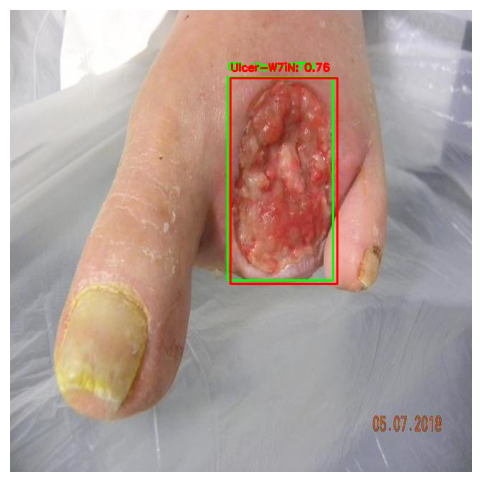

Processing image: /content/drive/MyDrive/DFU_Data_Yolo/test/images/100180_jpg.rf.b380435d70301a9dbd9477d130aa814d.jpg

0: 640x640 1 Ulcer-W7iN, 11.0ms
Speed: 2.8ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


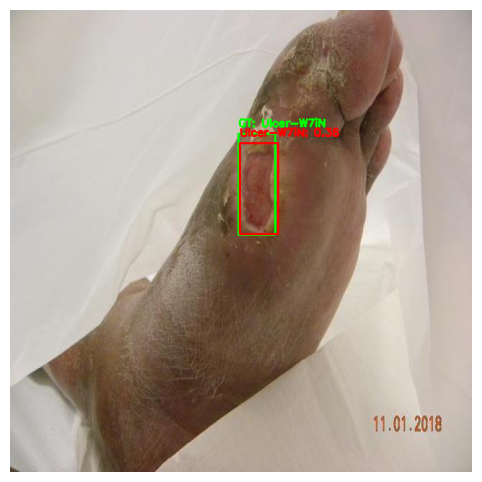

Processing image: /content/drive/MyDrive/DFU_Data_Yolo/test/images/100788_jpg.rf.30ad5363000a32da3db38b3bba34938f.jpg

0: 640x640 1 Ulcer-W7iN, 10.7ms
Speed: 2.1ms preprocess, 10.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


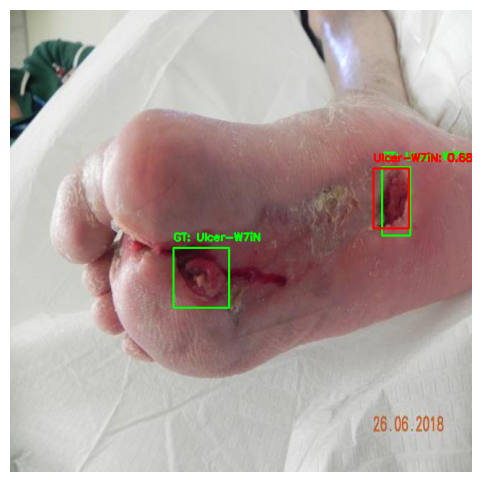

Processing image: /content/drive/MyDrive/DFU_Data_Yolo/test/images/100597_jpg.rf.932e37ac9ef1de5284e1be308437c8d7.jpg

0: 640x640 1 Ulcer-W7iN, 10.7ms
Speed: 2.6ms preprocess, 10.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


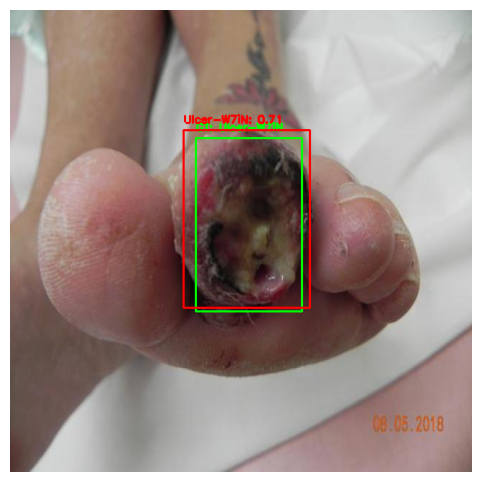

Processing image: /content/drive/MyDrive/DFU_Data_Yolo/test/images/100117_jpg.rf.03ab6854b152bd71d101f34f7dfac2b7.jpg

0: 640x640 (no detections), 10.8ms
Speed: 2.7ms preprocess, 10.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


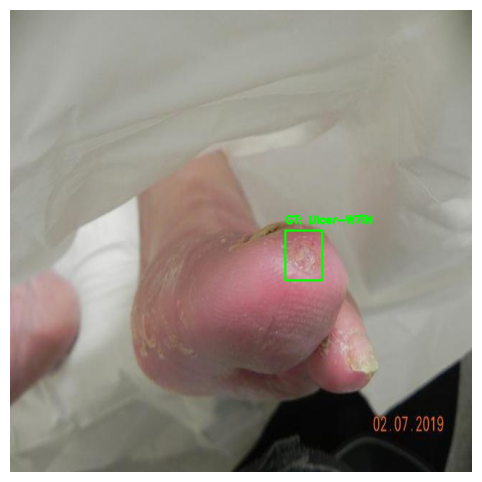

Processing image: /content/drive/MyDrive/DFU_Data_Yolo/test/images/100261_jpg.rf.26fdd311dd2dfb475800644ebb9c5883.jpg

0: 640x640 (no detections), 11.0ms
Speed: 2.5ms preprocess, 11.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


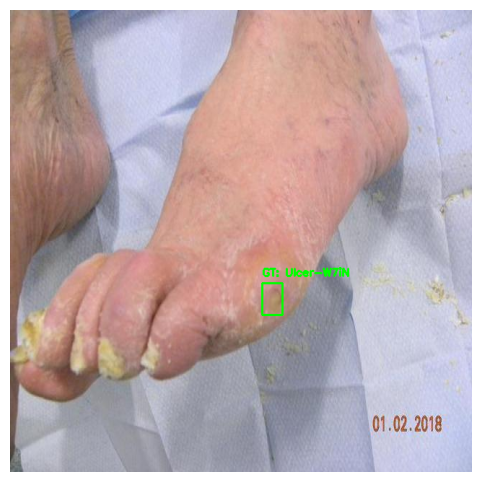

Processing image: /content/drive/MyDrive/DFU_Data_Yolo/test/images/101665_jpg.rf.43d088c5b6aa9186388b9858ed4f2bda.jpg

0: 640x640 1 Ulcer-W7iN, 10.7ms
Speed: 2.2ms preprocess, 10.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


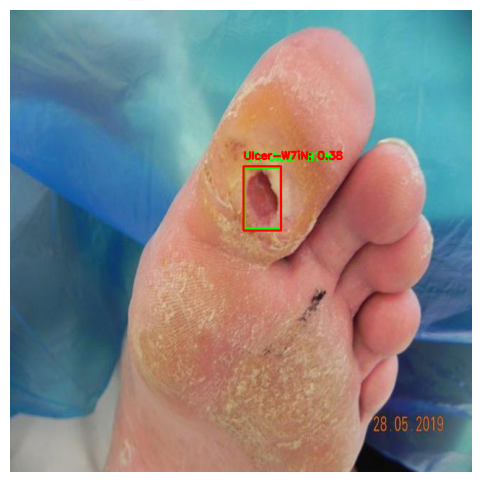

Processing image: /content/drive/MyDrive/DFU_Data_Yolo/test/images/101274_jpg.rf.6b669eedf0d342a3f15d6452f6c174d7.jpg

0: 640x640 1 Ulcer-W7iN, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


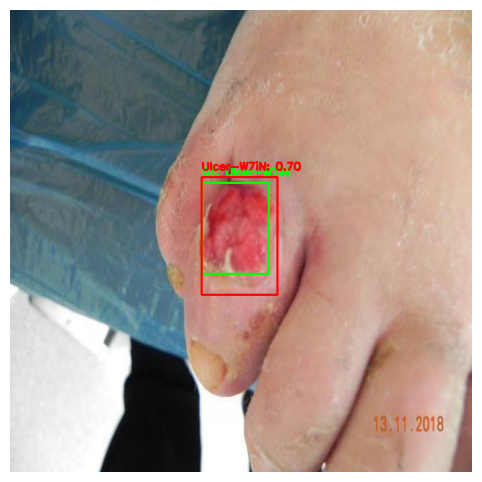

Processing image: /content/drive/MyDrive/DFU_Data_Yolo/test/images/101089_jpg.rf.34689710b5d23a2a0cf025136c448ff1.jpg

0: 640x640 1 Ulcer-W7iN, 10.7ms
Speed: 2.7ms preprocess, 10.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


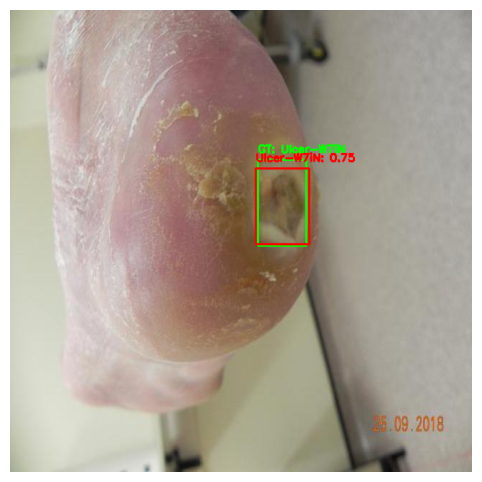

Processing image: /content/drive/MyDrive/DFU_Data_Yolo/test/images/101275_jpg.rf.b1ca2fe705d4f0d0bf392afbfafbf7fd.jpg

0: 640x640 (no detections), 10.9ms
Speed: 2.7ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


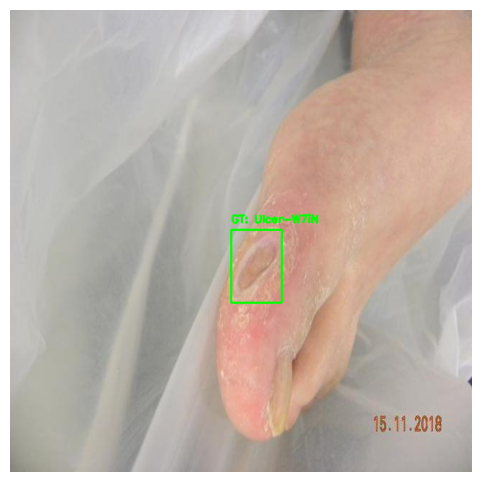

Processing image: /content/drive/MyDrive/DFU_Data_Yolo/test/images/101105_jpg.rf.fcd32f5ae8f301b437cb599fedf2c358.jpg

0: 640x640 (no detections), 10.8ms
Speed: 2.0ms preprocess, 10.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


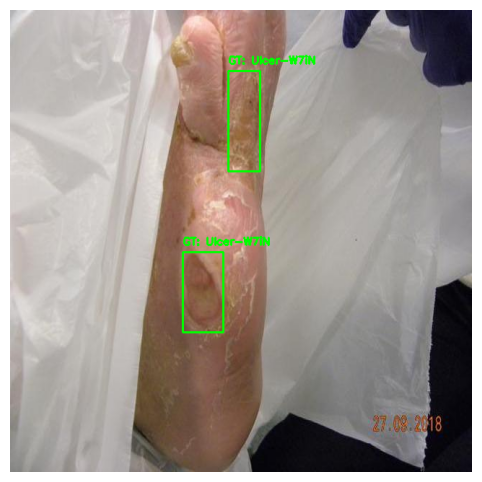

Processing image: /content/drive/MyDrive/DFU_Data_Yolo/test/images/101712_jpg.rf.856e9addd46ebcf5be8367524394b306.jpg

0: 640x640 1 Ulcer-W7iN, 10.7ms
Speed: 2.2ms preprocess, 10.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


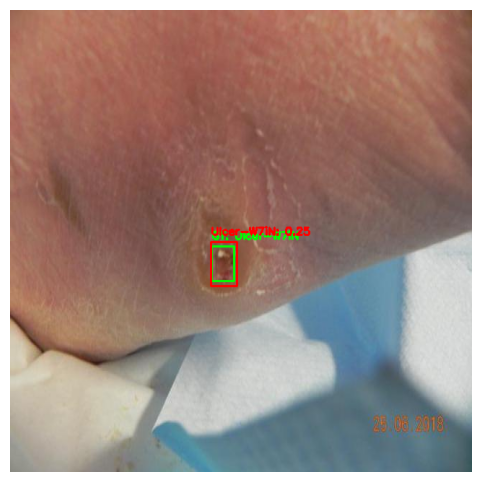

Processing image: /content/drive/MyDrive/DFU_Data_Yolo/test/images/101227_jpg.rf.19737115d2749696ebdcab1c8175478e.jpg

0: 640x640 3 Ulcer-W7iNs, 10.8ms
Speed: 2.5ms preprocess, 10.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


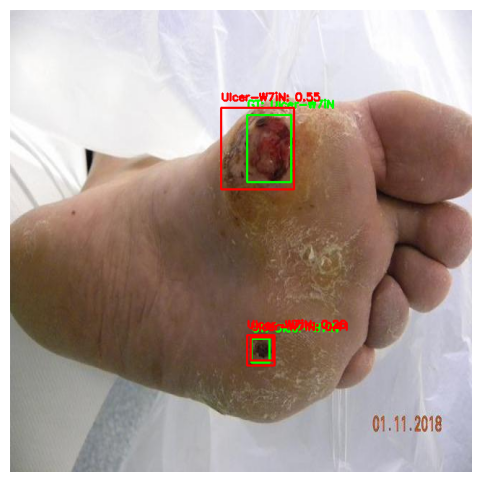

Processing image: /content/drive/MyDrive/DFU_Data_Yolo/test/images/100701_jpg.rf.8d4541ebafe32e0925f161422264c403.jpg

0: 640x640 1 Ulcer-W7iN, 10.7ms
Speed: 2.1ms preprocess, 10.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


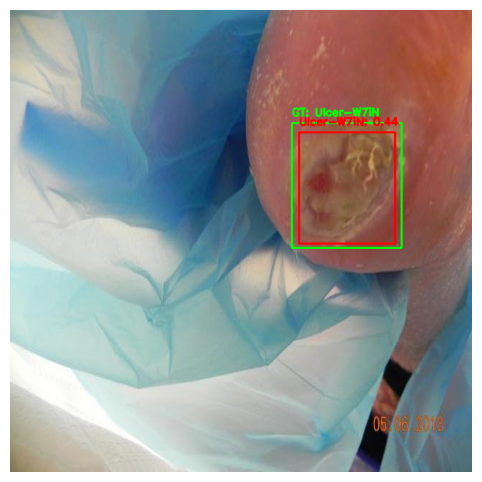

Processing image: /content/drive/MyDrive/DFU_Data_Yolo/test/images/100173_jpg.rf.4b633197d0424c4209d8feaca71c7c4f.jpg

0: 640x640 (no detections), 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


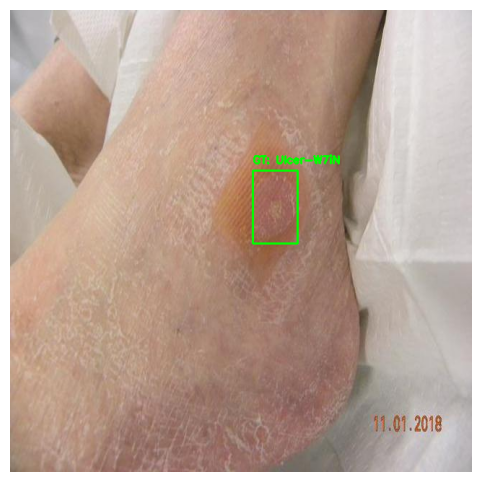

Processing image: /content/drive/MyDrive/DFU_Data_Yolo/test/images/100121_jpg.rf.b96a00f895aeeeff47e3166010b524bf.jpg

0: 640x640 1 Ulcer-W7iN, 10.7ms
Speed: 2.3ms preprocess, 10.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


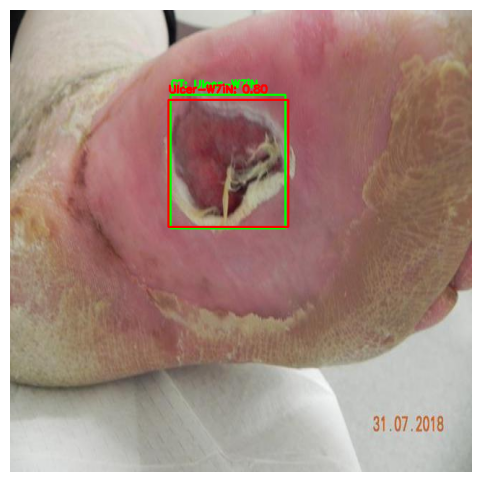

Processing image: /content/drive/MyDrive/DFU_Data_Yolo/test/images/100838_jpg.rf.250ab4e250e0f215583d53eb29a98d1d.jpg

0: 640x640 1 Ulcer-W7iN, 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


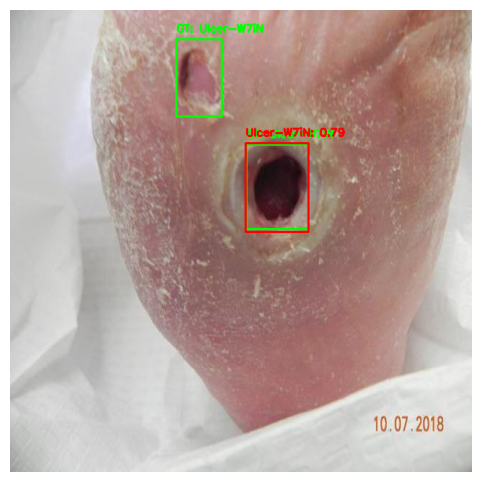

Processing image: /content/drive/MyDrive/DFU_Data_Yolo/test/images/101321_jpg.rf.19aebdf03a2b7b53b7c239f6fd71bb50.jpg

0: 640x640 1 Ulcer-W7iN, 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


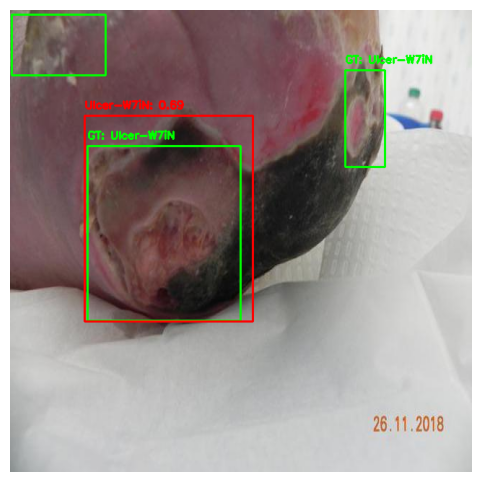

Processing image: /content/drive/MyDrive/DFU_Data_Yolo/test/images/100273_jpg.rf.6cc7b773b045b4134a2611ac22aec23e.jpg

0: 640x640 1 Ulcer-W7iN, 10.8ms
Speed: 2.7ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


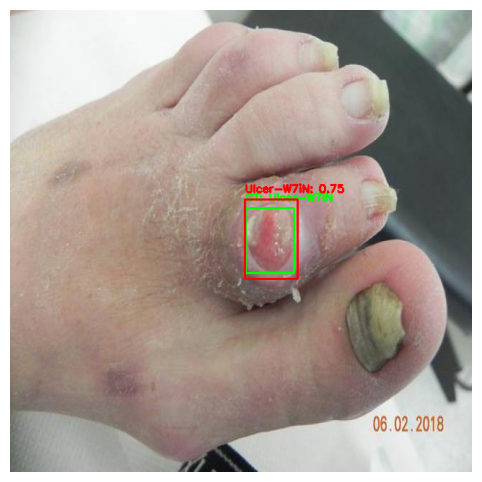

Processing image: /content/drive/MyDrive/DFU_Data_Yolo/test/images/100924_jpg.rf.a395936aab90891da216a59035f1ab48.jpg

0: 640x640 (no detections), 10.8ms
Speed: 2.8ms preprocess, 10.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


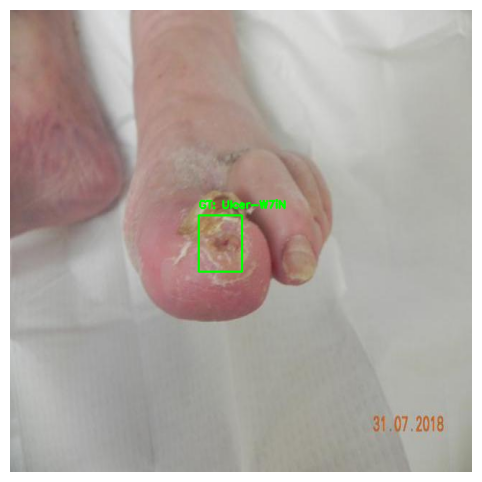

In [26]:
import cv2
import matplotlib.pyplot as plt

# Define colors in BGR format
GROUND_TRUTH_COLOR = (0, 255, 0)  # Green
PREDICTION_COLOR = (255, 0, 0)    # Blue

model = YOLO('/content/drive/MyDrive/best.onnx')


# Iterate over each test image
for img_path in test_image_files[:20]:

    # Load the image
    image = cv2.imread(img_path)
    img_height, img_width = image.shape[:2]
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(f"Processing image: {img_path}")

    # Perform inference
    results = model.predict(image_rgb)

    # Create a copy of the image to draw bounding boxes
    image_with_boxes = image_rgb.copy()

    # Draw ground truth bounding boxes
    ground_truth_boxes = get_ground_truth_boxes(img_path)
    for x1, y1, x2, y2, class_id in ground_truth_boxes:
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), GROUND_TRUTH_COLOR, 2)
        label = f'GT: {model.names[class_id]}'
        cv2.putText(image_with_boxes, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, GROUND_TRUTH_COLOR, 2)

    # Draw predicted bounding boxes with confidence scores
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]
            class_id = int(box.cls[0])
            label = f'{model.names[class_id]}: {confidence:.2f}'
            cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), PREDICTION_COLOR, 2)
            cv2.putText(image_with_boxes, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, PREDICTION_COLOR, 2)

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 6))
    plt.imshow(image_with_boxes)
    plt.axis('off')
    plt.show()

### Extracting scores for statistical testing

In [10]:
import os
from glob import glob
from tqdm import tqdm
from sklearn.metrics import average_precision_score
import cv2

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = max(1, (boxA[2] - boxA[0])) * max(1, (boxA[3] - boxA[1]))
    boxBArea = max(1, (boxB[2] - boxB[0])) * max(1, (boxB[3] - boxB[1]))
    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)

def load_yolo_ground_truth(image_path, img_shape):
    label_path = image_path.replace('images', 'labels').replace('.jpg', '.txt')
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                cls, x_center, y_center, width, height = map(float, line.strip().split())
                img_h, img_w = img_shape[:2]
                x1 = int((x_center - width / 2) * img_w)
                y1 = int((y_center - height / 2) * img_h)
                x2 = int((x_center + width / 2) * img_w)
                y2 = int((y_center + height / 2) * img_h)
                gt_boxes.append([x1, y1, x2, y2, int(cls)])
    return gt_boxes

def compute_per_image_map(image_dir, model):
    """
    Compute per-image mAP@0.5 for a YOLOv8 model on a given dataset split.

    Args:
        image_dir (str): Path to images folder (e.g. train/images).
        model (YOLO): Ultralytics YOLOv8 model (already loaded).

    Returns:
        dict: Mapping from image filename to mAP@0.5.
    """
    image_paths = sorted(glob(os.path.join(image_dir, '*.jpg')))
    image_map_scores = {}

    for img_path in tqdm(image_paths, desc=f"Evaluating {os.path.basename(image_dir)}"):
        results = model.predict(source=img_path, conf=0.001, iou=0.5, verbose=False)[0]

        img = results.orig_img
        if img is None:
            print(f"⚠️ Skipping unreadable image: {img_path}")
            continue

        img_h, img_w = img.shape[:2]

        # Predictions
        pred_boxes = []
        for box in results.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf[0])
            cls = int(box.cls[0])
            pred_boxes.append([x1, y1, x2, y2, cls, conf])

        # Ground truth
        gt_boxes = load_yolo_ground_truth(img_path, (img_h, img_w))

        y_true, y_scores = [], []

        for gt in gt_boxes:
            matched = False
            for pred in pred_boxes:
                iou = compute_iou(gt[:4], pred[:4])
                if iou >= 0.5 and gt[4] == pred[4]:
                    y_true.append(1)
                    y_scores.append(pred[5])
                    matched = True
                    break
            if not matched:
                y_true.append(1)
                y_scores.append(0)

        for pred in pred_boxes:
            if not any(compute_iou(pred[:4], gt[:4]) >= 0.5 and pred[4] == gt[4] for gt in gt_boxes):
                y_true.append(0)
                y_scores.append(pred[5])

        if len(set(y_true)) > 1:
            ap = average_precision_score(y_true, y_scores)
        else:
            ap = 0.0

        image_map_scores[os.path.basename(img_path)] = ap

    return image_map_scores


In [11]:
from ultralytics import YOLO

model = YOLO('/content/drive/MyDrive/best.onnx')

train_scores = compute_per_image_map('/content/drive/MyDrive/DFU_Data_Yolo/train/images', model)
test_scores  = compute_per_image_map('/content/drive/MyDrive/DFU_Data_Yolo/test/images', model)

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.


Evaluating images:   0%|          | 0/1159 [00:00<?, ?it/s]

Loading /content/drive/MyDrive/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider


Evaluating images: 100%|██████████| 1159/1159 [16:44<00:00,  1.15it/s]
Evaluating images: 0it [00:00, ?it/s]
Evaluating images: 100%|██████████| 165/165 [01:43<00:00,  1.60it/s]


In [12]:
val_scores   = compute_per_image_map('/content/drive/MyDrive/DFU_Data_Yolo/valid/images', model)

Evaluating images: 100%|██████████| 331/331 [04:47<00:00,  1.15it/s]


In [19]:
import pandas as pd

def save_map_csv(score_dict, column_name, filename):
    df = pd.DataFrame({
        'Image': list(score_dict.keys()),
        column_name: list(score_dict.values())
    })

    # Add average row using concat (not append)
    avg_row = {
        'Image': 'Average',
        column_name: df[column_name].mean()
    }
    df = pd.concat([df, pd.DataFrame([avg_row])], ignore_index=True)

    df.to_csv(filename, index=False)
    print(f"✅ Saved {filename}")


# Save all
save_map_csv(train_scores, 'train', '/content/drive/MyDrive/YOLO_per_image_map_comparison_train.csv')
save_map_csv(val_scores, 'valid', '/content/drive/MyDrive/YOLO_per_image_map_comparison_val.csv')
save_map_csv(test_scores, 'test', '/content/drive/MyDrive/YOLO_per_image_map_comparison_test.csv')

✅ Saved /content/drive/MyDrive/YOLO_per_image_map_comparison_train.csv
✅ Saved /content/drive/MyDrive/YOLO_per_image_map_comparison_val.csv
✅ Saved /content/drive/MyDrive/YOLO_per_image_map_comparison_test.csv
